In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
import numpy as np
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import time
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import scipy
from model import Poly_Net, Relu_Net

print('cuda available: ', torch.cuda.is_available())

# use either cpu or gpu
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"



cuda available:  True


In [3]:
#use minmax scaler instead
def read_data(path, y_list, s="\s+"):
    x = pd.read_csv(path, sep=s, header=None)
    # x = pd.DataFrame(x)
    x = x.to_numpy()
    y = []
    y_list.sort(reverse=True)
    for i in y_list:
        y.append(x[:,i])
        # housing_normed = np.delete(housing_normed, 4, 1)
        x = np.delete(x, i, 1)
    y = np.transpose(y)
    return x, y
    
def prep_data(x_train, x_test, y_train, y_test):
    # prep x data
    x_train = pd.DataFrame(data=x_train)
    z_scores = x_train.apply(scipy.stats.zscore, nan_policy='omit')
    x_train.where(abs(z_scores) < 3, inplace=True)
    x_train = x_train.fillna(x_train.mean())
    x_train = x_train.to_numpy()
    scaler = MinMaxScaler((1, math.exp(1)))
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    # prep y data
    y_train = pd.DataFrame(data=y_train)
    z_scores = y_train.apply(scipy.stats.zscore, nan_policy='omit')
    y_train.where(abs(z_scores) < 3, inplace=True)
    y_train = y_train.fillna(y_train.mean())
    y_train = y_train.to_numpy()
    # scaler = MinMaxScaler((1, math.exp(1)))
    scaler.fit(y_train)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    return torch.FloatTensor(x_train).to(device), torch.FloatTensor(x_test).to(device), torch.FloatTensor(y_train).to(device), torch.FloatTensor(y_test).to(device)


In [4]:
x, y = read_data('C:\\Users\\Ahmet\\ETH_Master\\DeepLearning\\feature_learning_project\\Datasets\\housing.data', [13])

In [5]:
def train_and_test(X, y, nnet, mon_dim, b1, b2, bs, lr, max_epochs=1000, nsplits=5, printout=100, show_pred=False):
    # X, y = make_data(n, f_num)
    strt=time.time()
    input_dim = X.shape[1]
    kf = KFold(n_splits=nsplits, shuffle=True)
    # loss list for every k fold
    k_loss = [[] for _ in range(nsplits)]
    val_loss = []
    for j, indices in enumerate(kf.split(X)):
        print('\n============= split '+str(j+1)+' =============\n')
        train_index, test_index = indices
        # print(type(train_index), type(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, X_test, y_train, y_test = prep_data(X_train, X_test, y_train, y_test)
        # prev_loss = inf
        out_dim = y.shape[1]
        if nnet == 'poly':
            net = Poly_Net(input_dim, mon_dim, out_dim, b1, b2)
        else:
            net = Relu_Net(input_dim, mon_dim, out_dim, b1, b2)
        net.to(device)
        criterion = nn.MSELoss()
        # optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.005)
        training_data = DataLoader(list(zip(X_train, y_train)), batch_size=bs, shuffle=True)
        for epoch in range(max_epochs):  # loop over the dataset multiple times
            running_loss = 0.0
            for i, data in enumerate(training_data):
                # get the inputs; data is a list of [inputs, labels]
                inputs, result = data
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = net(inputs.to(device))
                loss = criterion(outputs, result)
                loss.backward()
                # nn.utils.clip_grad_norm_(net.parameters(), max_norm=clip_norm)
                optimizer.step()
                # clamp zero vals
                if isinstance(net, Poly_Net):
                    with torch.no_grad():
                        net.lin_hidden.weight.clamp_(0.)
                # print statistics
                running_loss += loss.item()
            k_loss[j].append(running_loss/len(training_data))
            if epoch % printout == printout-1:
                print('epoch: ', epoch+1, '; loss: ', running_loss/len(training_data))
        # validation set
        out = net(X_test)
        loss = criterion(out, y_test)
        print('\nvalidation loss: ', loss.item())
        val_loss.append(loss.item())
    print('\n\n--------------\n\n')
    print('average loss: ', sum(val_loss)/nsplits)
    print('cross validation train and test took: '+str(time.time()-strt))
    return k_loss, val_loss


In [13]:
def train_and_test_linreg(X, y, nsplits=5):
    input_dim = X.shape[1]
    kf = KFold(n_splits=nsplits, shuffle=True)
    # loss list for every k fold
    val_loss = []
    for j, indices in enumerate(kf.split(X)):
        print('-- split: ', j+1)
        train_index, test_index = indices
        # print(type(train_index), type(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, X_test, y_train, y_test = prep_data(X_train, X_test, y_train, y_test)
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        loss = mean_squared_error(y_test, y_pred)
        val_loss.append(loss)
        print('val loss: ', loss)
    print('average loss: ', sum(val_loss)/nsplits)
    return val_loss

In [7]:
# plot the loss along learning epochs for all folds and finally compute the average learning loss across the folds with 'avgs'
def k_plots(k_losses, colors):
    plt.yscale('log')
    for i, kl in enumerate(k_losses):
        assert len(kl) > 0
        avgs = [0 for _ in kl[0]]
        for _, k in enumerate(kl):
            plt.plot(k, alpha=0.3, color=colors[i])
            for j, ki in enumerate(k):
                avgs[j] += ki
        avgs = [x/len(kl) for x in avgs]
        plt.plot(avgs, color=colors[i])
    plt.show()


In [8]:
poly_k_loss, poly_v_loss = train_and_test(X=x, y=y, nnet='poly', mon_dim=100, b1=False, b2=True, bs=8, lr=0.0005, max_epochs=5000, nsplits=5, printout=500)


============= split 1 =============

epoch:  500 ; loss:  0.03527707347244609
epoch:  1000 ; loss:  0.03234322272314161
epoch:  1500 ; loss:  0.03101536039920414
epoch:  2000 ; loss:  0.03049576472417981
epoch:  2500 ; loss:  0.028821927979223283
epoch:  3000 ; loss:  0.02747746852829176
epoch:  3500 ; loss:  0.027260669507086277
epoch:  4000 ; loss:  0.026303430133517467
epoch:  4500 ; loss:  0.027206753033633325
epoch:  5000 ; loss:  0.02568385691619387

validation loss:  0.03662215918302536

============= split 2 =============

epoch:  500 ; loss:  0.03298349679429449
epoch:  1000 ; loss:  0.03171210641990982
epoch:  1500 ; loss:  0.028927235325396646
epoch:  2000 ; loss:  0.027356383062022573
epoch:  2500 ; loss:  0.025237201493890846
epoch:  3000 ; loss:  0.024478995862106483
epoch:  3500 ; loss:  0.02415471060165003
epoch:  4000 ; loss:  0.023159517851822516
epoch:  4500 ; loss:  0.023479872310132373
epoch:  5000 ; loss:  0.024401035938211076

validation loss:  0.033697396516799

In [15]:
net_k_loss, net_v_loss = train_and_test(X=x, y=y, nnet='net', mon_dim=100, b1=True, b2=True, bs=8, lr=0.0005, max_epochs=5000, nsplits=5, printout=500)


============= split 1 =============

epoch:  500 ; loss:  0.020010196142738648
epoch:  1000 ; loss:  0.02058387422185464
epoch:  1500 ; loss:  0.0190998509083418
epoch:  2000 ; loss:  0.019004812496075153
epoch:  2500 ; loss:  0.0190542159035948
epoch:  3000 ; loss:  0.019045248495268764
epoch:  3500 ; loss:  0.02011498700663009
epoch:  4000 ; loss:  0.018994723218401857
epoch:  4500 ; loss:  0.019305759319560786
epoch:  5000 ; loss:  0.018993947184735946

validation loss:  0.0535273402929306

============= split 2 =============

epoch:  500 ; loss:  0.02555889115604919
epoch:  1000 ; loss:  0.022951133252468472
epoch:  1500 ; loss:  0.022519184080153413
epoch:  2000 ; loss:  0.021509906587501366
epoch:  2500 ; loss:  0.02200230358022393
epoch:  3000 ; loss:  0.022504017943991164
epoch:  3500 ; loss:  0.021356042029390877
epoch:  4000 ; loss:  0.02218932434733884
epoch:  4500 ; loss:  0.022943798247176933
epoch:  5000 ; loss:  0.022304002506037552

validation loss:  0.0329548455774784

In [14]:
linreg_v_loss = train_and_test_linreg(X=x, y=y, nsplits=5)

-- split:  1
val loss:  0.02592131
-- split:  2
val loss:  0.056948237
-- split:  3
val loss:  0.0391056
-- split:  4
val loss:  0.059521414
-- split:  5
val loss:  0.036416467
average loss:  0.04358260594308376


<IPython.core.display.Javascript object>


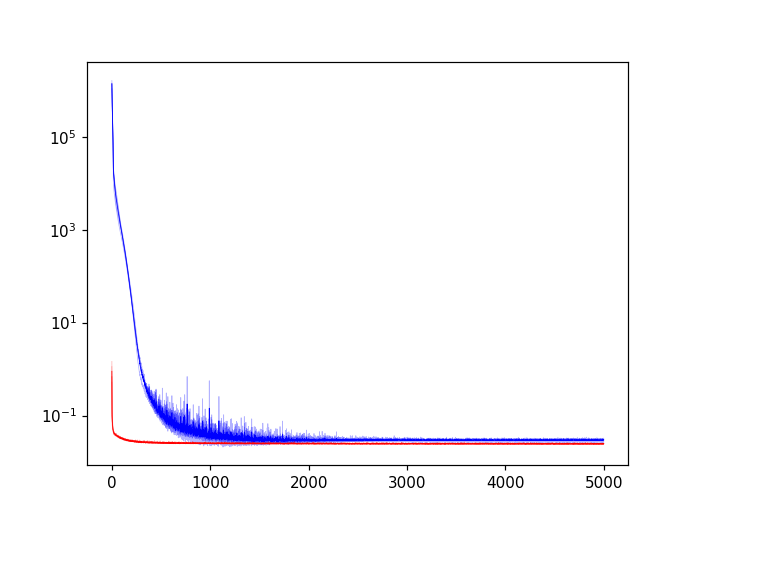

In [56]:
%matplotlib notebook
k_plots_2(poly_k_loss, net_k_loss, c='blue', c2='red')